# NLモデルの推定2
以下の図のモデル構造のものを推定する

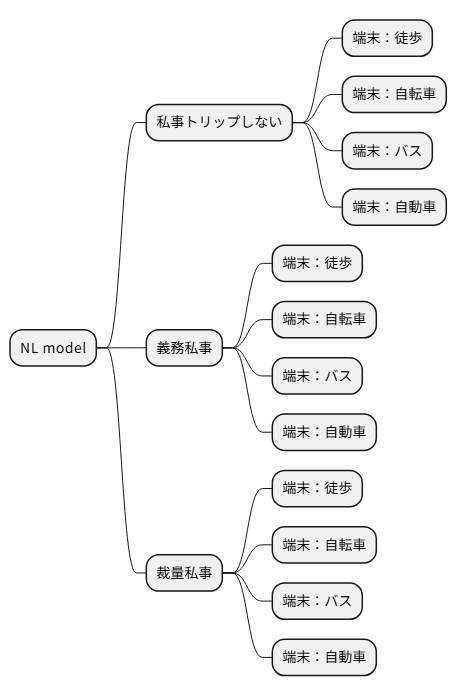

In [1]:
# ライブラリの導入
import pandas as pd
import biogeme.biogeme_logging as blog

from biogeme.database import Database
from biogeme.expressions import Variable, Beta
from biogeme.biogeme import BIOGEME
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 入力データの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/c_NL_Logit_master1.csv", encoding="utf-8-sig")
master_df = master_df.fillna(0) # 欠損値を一応埋める

# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)

# NL用のCHOICEカラムを作成する
mode_map = {1:0, 2:1, 4:2, 5:3} # 端末手段を0~3にまとめる
priv_map = {0:0, 1:1, 2:2} # 私事なしと私事種類で0~2でまとめる
# 書き換え（のちに12種類の選択肢にするため）
master_df["t_first_transportation"] = master_df["first_transportation"].map(mode_map)
master_df["t_PriTrip_class"] = master_df["PriTrip_class"].map(priv_map)
# CHOICEカラムの作成（1~12が入力される）
master_df["CHOICE"] = (master_df["t_first_transportation"] + 4 * master_df["t_PriTrip_class"] + 1).astype(int)
# 私事トリップしない＝｛1, 2, 3, 4｝
# 義務私事={5, 6, 7, 8}
# 裁量私事={9, 10, 11, 12}

# 確認
print(len(master_df))
print(master_df["CHOICE"].isna().sum())
master_df.columns

46733
0


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'YoungestMember_No', 'WorkTime[m]',
       'AfterTime_work[m]', 'AfterTime_home[m]', 'first_transportation',
       'NearestStation_code', 'near_area_syou', 'near_area_kinrin',
       'near_area_sum', 'near_area_syou500', 'near_area_kinrin500',
       'near_area_sum500', 'near_area_syou300', 'near_area_kinrin300',
       'near_area_sum300', 'near_o_area_syou', 'near_o_area_kinrin',
       'near_o_area_sum', 'near_o_area_syou500', 'near_o_area_kinrin500',
       'near_o_area_sum500', 'near_o_area_syou300', 'near_o_area_kinrin300',
       'near_o_area_sum300', 'WorkplaceStation_code', 'WP_area_syou',
       'WP_area_kinrin', 'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500',
       'WP_area_sum500', 'WP_area_syou300', 'WP_area_kinrin300',
       'WP_area_sum300', 'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_ar

In [3]:
# CHOICEの数を確認
master_df["CHOICE"].value_counts().sort_index()

CHOICE
1     28189
2      4472
3      4294
4      1178
5      2954
6       440
7       299
8        65
9      3913
10      420
11      417
12       92
Name: count, dtype: int64

In [4]:
tt_cols = ["walk_time[m]","bicycle_time[m]","bus_time[m]","car_time[m]"]
x_cols  = ["WorkTime[m]","MainlineTime[m]","near_area_syou300","HouseholdMembers(all)"]

for c in tt_cols + x_cols:
    s = master_df[c]
    print(c, "min", s.min(), "p99", s.quantile(0.99), "max", s.max())


walk_time[m] min 1.1962972527174662 p99 62.67926942221522 max 242.9540133776009
bicycle_time[m] min 0.3828151208695892 p99 20.057366215108875 max 77.74528428083228
bus_time[m] min 0.0 p99 28.65639199317705 max 103.64578133457104
car_time[m] min 1.1857748682791032 p99 14.822285608052628 max 36.92665830300816
WorkTime[m] min 245.0 p99 835.0 max 876.0
MainlineTime[m] min 6.613042032740628 p99 120.4312634879544 max 140.79257775223496
near_area_syou300 min 0.0 p99 1851965.0016133816 max 2981425.437288304
HouseholdMembers(all) min 1 p99 5.0 max 9


In [5]:
# biogemeデータリストに格納する
master_db = Database("PTdata", master_df)

### 省略一覧
#### トリップ関連
- NO: No Trip
- DU: Duty
- DI: Discretion

#### モード関連
- WA: Walk
- BI: Bicycle
- BU: Bus
- CA: Car

In [6]:
# 変数の定義
# output
CHOICE = Variable("CHOICE")

# input
# traffic_mode
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")
BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")
BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")
CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip_choice
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]") # 通勤メイン時間
HHM_all     = Variable("HouseholdMembers(all)") # 世帯人数
NEKI_INDEX  = Variable("near_area_syou300") # 最寄駅土地利用指標
WEKI_INDEX  = Variable("WP_area_syou300") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60) # 1時間当たりの変化

NEKI_INDEX_SCALED = master_db.define_variable("NEKI_INDEX_SCALED", NEKI_INDEX / 1000000)
WEKI_INDEX_SCALED = master_db.define_variable("WEKI_INDEX_SCALED", WEKI_INDEX / 1000000)

# alternative specific constant
# traffic mode
ASC_WA = Beta("ASC_WA", 0, None, None, 1)  # fixed base
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)
# Trip_choice
ASC_NO = Beta("ASC_NO", 0, None, None, 1)  # 私事トリップなし固定
ASC_DU = Beta("ASC_DU", 0, None, None, 0)  # 義務
ASC_DI = Beta("ASC_DI", 0, None, None, 0)  # 裁量

# parameters
b_at = Beta("b_at", 0, None, None, 0)

b_work        = Beta("b_work", 0, None, None, 0)
b_aftime_work = Beta("aftime_work", 0, None, None, 0)
b_macmtime    = Beta("b_macmtime", 0, None, None, 0)
b_hhm         = Beta("b_hhm", 0, None, None, 0)
b_n_eki       = Beta("b_n_eki", 0, None, None, 0)
b_w_eki       = Beta("b_w_eki", 0, None, None, 0)

# ネストパラメータ
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)      # 参照として固定（=logit相当）
MU_DU = Beta("MU_DU", 1.2, 1.0, 10.0, 0)     # 推定
MU_DI = Beta("MU_DI", 1.2, 1.0, 10.0, 0)     # 推定

# Alternative_ID（選択肢の説明）
NO_WA, NO_BI, NO_BU, NO_CA = 1, 2, 3, 4 # 私事トリップしない
DU_WA, DU_BI, DU_BU, DU_CA = 5, 6, 7, 8 # 義務私事
DI_WA, DI_BI, DI_BU, DI_CA = 9, 10, 11, 12 # 裁量私事

# Utility（効用関数）
# PriTrip
V_NO_PRI = ASC_NO
V_DU_PRI = (ASC_DU
            + b_work     * WORKTIME_SCALED
            + b_macmtime * MACMTIME_SCALED
            + b_n_eki    * NEKI_INDEX_SCALED
            + b_hhm      * HHM_all)

V_DI_PRI = (ASC_DI
            + b_work     * WORKTIME_SCALED
            + b_macmtime * MACMTIME_SCALED
            + b_n_eki    * NEKI_INDEX_SCALED
            + b_hhm      * HHM_all)

PEN = 30
# mode
V_WA_MODE = ASC_WA + b_at * WA_TT - PEN * (1 - WA_AV)
V_BI_MODE = ASC_BI + b_at * BI_TT - PEN * (1 - BI_AV)
V_BU_MODE = ASC_BU + b_at * BU_TT - PEN * (1 - BU_AV)
V_CA_MODE = ASC_CA + b_at * CA_TT - PEN * (1 - CA_AV)

# for 12alternative
V = {
    NO_WA: V_NO_PRI + V_WA_MODE,
    NO_BI: V_NO_PRI + V_BI_MODE,
    NO_BU: V_NO_PRI + V_BU_MODE,
    NO_CA: V_NO_PRI + V_CA_MODE,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability
av = {
    NO_WA: WA_AV, NO_BI: BI_AV, NO_BU: BU_AV, NO_CA: CA_AV,
    DU_WA: WA_AV, DU_BI: BI_AV, DU_BU: BU_AV, DU_CA: CA_AV,
    DI_WA: WA_AV, DI_BI: BI_AV, DI_BU: BU_AV, DI_CA: CA_AV
}

# nests(upper level = PriTrip)
nest_NO = OneNestForNestedLogit(MU_NO, [NO_WA, NO_BI, NO_BU, NO_CA], name="NoTrip")
nest_DU = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_DI = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_NO, nest_DU, nest_DI),
)

In [7]:
#estimate
logprob = lognested(V, None, nests, CHOICE)

logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(master_db, logprob, 
                  generate_html=False, generate_yaml=False, # 推定結果保存可否
                  optimization_algorithm="simple_bounds_BFGS")
biogeme.model_name = "NL_mode_then_private3_v2"

biogeme.calculate_null_loglikelihood(av)
results = biogeme.estimate()

print(results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results = get_pandas_estimated_parameters(estimation_results=results)
print(pandas_results)

Biogeme parameters read from biogeme.toml. 
*** Initial values of the parameters are obtained from the file __NL_mode_then_private3_v2.iter 
Parameter values restored from __NL_mode_then_private3_v2.iter 
Starting values for the algorithm: {'b_at': -0.2855243010663368, 'ASC_BI': -4.343959898188557, 'ASC_BU': -2.067353379139248, 'ASC_CA': -6.1209510280005714, 'ASC_DU': 4.034159582443927, 'b_work': -0.535343100245264, 'b_macmtime': -0.6326174581692314, 'b_n_eki': 0.06223242333791953, 'b_hhm': -0.2613072245909186, 'MU_DU': 1.0269518882441613, 'ASC_DI': 4.305430459465009, 'MU_DI': 1.0765631080444213} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
Optimization algorithm has converged. 
Relative gradient: 5.896321132849359e-06 
Cause of termination: Relative gradient = 5.9e-06 <= 6.1e-06 
Number of function evaluations: 1 
Number o

Results for model NL_mode_then_private3_v2
Nbr of parameters:		12
Sample size:			46733
Excluded data:			0
Null log likelihood:		-92260.29
Final log likelihood:		-47055.69
Likelihood ratio test (null):		90409.2
Rho square (null):			0.49
Rho bar square (null):			0.49
Akaike Information Criterion:	94135.37
Bayesian Information Criterion:	94240.4

          Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         b_at -0.285524         0.003417      -83.562047        0.000000
1       ASC_BI -4.343960         0.038619     -112.483792        0.000000
2       ASC_BU -2.067353         0.024291      -85.107832        0.000000
3       ASC_CA -6.120951         0.054047     -113.252259        0.000000
4       ASC_DU  4.034160         0.096661       41.734954        0.000000
5       b_work -0.535343         0.008938      -59.895693        0.000000
6   b_macmtime -0.632617         0.033732      -18.754254        0.000000
7      b_n_eki  0.062232         0.027845        2.234981     

# 感度分析の実施
- 端末時間と通勤メイン時間による私事トリップへの影響
- 端末時間（徒歩固定）による私事トリップへの影響
- 通勤メイン時間による私事トリップへの影響
- 就業時間による私事トリップへの影響

In [8]:
# ライブラリの追加
import numpy as np
import matplotlib.pyplot as plt

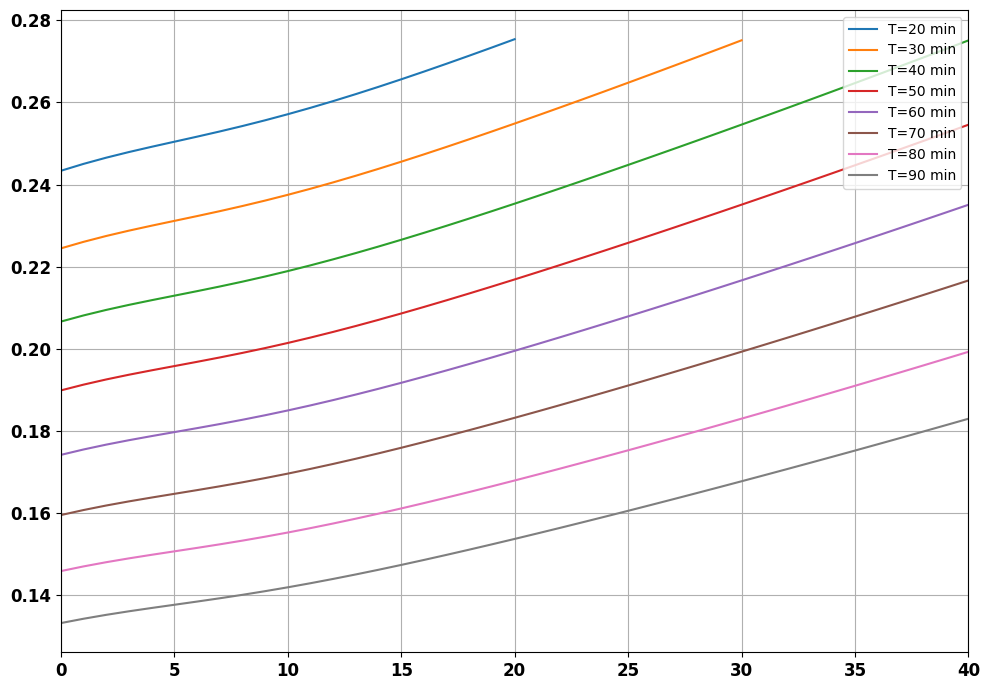

In [ ]:
# 端末時間と通勤メイン時間による私事トリップへの影響
# パラメータの取得
b = results.get_beta_values()

# 平均値の取得（スケーリングが必要な場合はここで行う）
m_work_h = master_df["WorkTime[m]"].mean() / 60
m_macm_h = master_df["MainlineTime[m]"].mean() / 60
m_neki_s = 677535.273703768 / 1e6 # 阿佐ヶ谷駅
m_weki_s = master_df["WP_area_syou300"].mean() / 1e6
m_hhm    = 2 # 二人世帯

# 端末モードの固定値（徒歩以外）
m_bi_t = master_df["bicycle_time[m]"].mean()
m_bu_t = master_df["bus_time[m]"].mean()
m_ca_t = master_df["car_time[m]"].mean()

# 定数項と係数の取り出し（見やすくするため）
asc_wa, asc_bi, asc_bu, asc_ca = 0, b['ASC_BI'], b['ASC_BU'], b['ASC_CA']
b_at = b['b_at']

# 対数和と確率の計算を行う関数の定義
def calc_p(walk_time, mainline_time):
    # 下位層（端末モード）（PEN項はAV=1と固定して0になるため省略）
    V_wa = asc_wa + b_at * walk_time # 可変
    V_bi = asc_bi + b_at * m_bi_t
    V_bu = asc_bu + b_at * m_bu_t
    V_ca = asc_ca + b_at * m_ca_t

    # 対数和の算出（logsumとinclusive value（合成効用））
    mu_no = 1 # 固定＝１
    mu_du = b["MU_DU"]
    mu_di = b["MU_DI"]

    # 各ネストのlogsum
    iv_no = np.log(np.exp(V_wa/mu_no) + np.exp(V_bi/mu_no) + np.exp(V_bu/mu_no) + np.exp(V_ca/mu_no))
    iv_du = np.log(np.exp(V_wa/mu_du) + np.exp(V_bi/mu_du) + np.exp(V_bu/mu_du) + np.exp(V_ca/mu_du))
    iv_di = np.log(np.exp(V_wa/mu_di) + np.exp(V_bi/mu_di) + np.exp(V_bu/mu_di) + np.exp(V_ca/mu_di))

    #位層（目的）の効用 V_purpose
    # 共通部分 (Common Utility)
    # ※ b_macmtime が効くのは DU と DI です
    
    # NO (Tripなし)
    v_no_pri = 0 + mu_no * iv_no
    
    # DU (義務)
    v_du_common = (b['ASC_DU'] 
                   + b['b_work'] * m_work_h
                   + b['b_macmtime'] * (mainline_time / 60.0)
                   + b['b_n_eki'] * m_neki_s
                   + b['b_hhm'] * m_hhm)
    v_du_pri = v_du_common + mu_du * iv_du
    
    # DI (裁量)
    v_di_common = (b['ASC_DI'] 
                   + b['b_work'] * m_work_h
                   + b['b_macmtime'] * (mainline_time / 60.0)
                   + b['b_n_eki'] * m_neki_s
                   + b['b_hhm'] * m_hhm)
    v_di_pri = v_di_common + mu_di * iv_di
    
    # --- D. 選択確率の計算 ---
    denom = np.exp(v_no_pri) + np.exp(v_du_pri) + np.exp(v_di_pri)
    
    prob_pri = (np.exp(v_du_pri) + np.exp(v_di_pri)) / denom
    
    return prob_pri

# ---------------------------------------------------------
# 3. プロット実行（修正箇所）
# ---------------------------------------------------------
plt.figure(figsize=(10, 7))

# 総通勤時間 (Total Time) のケース: 20分〜90分
Total_Times = range(20, 91, 10) 

# X軸：端末徒歩時間 (t)
t_access_range = np.linspace(0, 40, 41) 

for T_total in Total_Times:
    # 【重要】本線時間を計算： 総時間 - 端末時間
    # Mainline = Total - Access
    t_mainline_array = T_total - t_access_range
    
    # 物理的にあり得ないケース（本線時間がマイナスになる場合）を除外またはNaNにする処理
    # 例: 総時間が20分なのに徒歩が30分の場合など
    valid_mask = t_mainline_array >= 0
    
    # 有効な範囲のデータのみ抽出
    t_acc  = t_access_range[valid_mask]
    t_main = t_mainline_array[valid_mask]
    
    # プロットすべきデータがある場合のみ描画
    if len(t_acc) > 0:
        p_pri = calc_p(t_acc, t_main)
        plt.plot(t_acc, p_pri, label=f"T={T_total} min")

# --- グラフの装飾 (画像に合わせる) ---
plt.xlim(0, 40)
# plt.ylim(0.10, 0.25) # 画像のようなY軸範囲に固定したい場合はコメントアウトを外す

plt.grid(True) # グリッド表示
plt.legend(loc='upper right', fontsize=10) # 凡例

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# ラベルなど（必要に応じて日本語フォント設定を行ってください）
# plt.xlabel("Access Time [min]")
# plt.ylabel("Probability")

plt.tight_layout()
plt.show()

In [ ]:
from biogeme import models
# 推定済みパラメータの取得
beta_hat = results.get_beta_values()

# 各代替の選択確率
P = {
    "P_W_NO":   models.nested(V, None, nests, W_NO),
    "P_W_DUTY": models.nested(V, None, nests, W_DUTY),
    "P_W_DISC": models.nested(V, None, nests, W_DISCRETION),

    "P_BI_NO":   models.nested(V, None, nests, BI_NO),
    "P_BI_DUTY": models.nested(V, None, nests, BI_DUTY),
    "P_BI_DISC": models.nested(V, None, nests, BI_DISCRETION),

    "P_BU_NO":   models.nested(V, None, nests, BU_NO),
    "P_BU_DUTY": models.nested(V, None, nests, BU_DUTY),
    "P_BU_DISC": models.nested(V, None, nests, BU_DISCRETION),

    "P_C_NO":   models.nested(V, None, nests, C_NO),
    "P_C_DUTY": models.nested(V, None, nests, C_DUTY),
    "P_C_DISC": models.nested(V, None, nests, C_DISCRETION),
}

biogeme_sim = BIOGEME(master_db, P, generate_html=False, generate_yaml=False)
sim = biogeme_sim.simulate(beta_hat)

# モード別に合計確率
sim["P_WALK"] = sim["P_W_NO"] + sim["P_W_DUTY"] + sim["P_W_DISC"]
sim["P_BIC"]  = sim["P_BI_NO"] + sim["P_BI_DUTY"] + sim["P_BI_DISC"]
sim["P_BUS"]  = sim["P_BU_NO"] + sim["P_BU_DUTY"] + sim["P_BU_DISC"]
sim["P_CAR"]  = sim["P_C_NO"] + sim["P_C_DUTY"] + sim["P_C_DISC"]

# “不可用なのに確率が付いている量”を評価（平均と最大）
df = master_df.copy()
df = df.join(sim)

df["P_BIC_if_unavail"] = (1 - df["bicycle_av"]) * df["P_BIC"]
df["P_BUS_if_unavail"] = (1 - df["bus_av"])     * df["P_BUS"]
df["P_CAR_if_unavail"] = (1 - df["car_av"])     * df["P_CAR"]

print("Mean P(BIC | unavail):", df["P_BIC_if_unavail"].mean())
print("Max  P(BIC | unavail):", df["P_BIC_if_unavail"].max())
print("Mean P(BUS | unavail):", df["P_BUS_if_unavail"].mean())
print("Max  P(BUS | unavail):", df["P_BUS_if_unavail"].max())
print("Mean P(CAR | unavail):", df["P_CAR_if_unavail"].mean())
print("Max  P(CAR | unavail):", df["P_CAR_if_unavail"].max())
# 出力が限りなく小さければ良い．ここで出力される値はav=0なのに，そのモードに割り当てられてしまった確率質量を示している

Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 


Mean P(BIC | unavail): 4.737358781966329e-15
Max  P(BIC | unavail): 1.7804305290385605e-12
Mean P(BUS | unavail): 7.468056676185785e-14
Max  P(BUS | unavail): 4.2327705790935945e-13
Mean P(CAR | unavail): 1.2091876970475252e-15
Max  P(CAR | unavail): 3.251433250692663e-13


In [ ]:
# 各モードで端末1分による私事トリップ確率変動を算出
beta_hat = results.get_beta_values()
b_at = beta_hat["b_at"]

df = master_df.copy().join(sim)

# 1分の増分
delta = 1  # min
# delta = 1.0 # ←もし端末時間を「分」で入れているならこちら

# ===== 自分への効果（各モードの時間を1分増やす）=====
for m in ["WALK", "BIC", "BUS", "CAR"]:
    Pm = df[f"P_{m}"]
    df[f"dP_{m}_per1min_{m}time"] = Pm * (1 - Pm) * b_at * delta

# 平均（%ポイント換算）
for m in ["WALK", "BIC", "BUS", "CAR"]:
    ame = df[f"dP_{m}_per1min_{m}time"].mean() * 100
    print(f"Average marginal effect: +1min of {m} time -> dP({m}) = {ame:.6f} %-points")

# ===== クロス効果の例：歩行時間を1分増やしたとき他モードがどう動くか =====
Pk = df["P_WALK"]
for m in ["BIC", "BUS", "CAR"]:
    Pm = df[f"P_{m}"]
    df[f"dP_{m}_per1min_WALKtime"] = -Pm * Pk * b_at * delta

print("Cross effects (mean, %-points) when +1min WALK time:")
for m in ["BIC", "BUS", "CAR"]:
    print(m, df[f"dP_{m}_per1min_WALKtime"].mean() * 100)

Average marginal effect: +1min of WALK time -> dP(WALK) = -2.627767 %-points
Average marginal effect: +1min of BIC time -> dP(BIC) = -2.335231 %-points
Average marginal effect: +1min of BUS time -> dP(BUS) = -1.780226 %-points
Average marginal effect: +1min of CAR time -> dP(CAR) = -0.678643 %-points
Cross effects (mean, %-points) when +1min WALK time:
BIC 1.5099073416819457
BUS 0.8773161962546794
CAR 0.24054371168811253
